# Raccoon denoising

## Setup

In [1]:
%matplotlib inline
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.INFO)
plt.rc("text", usetex=True)
plt.rc('font', family='serif', size=14)

In [2]:
from tramp.variables import SIMOVariable, MILeafVariable, SISOVariable as V, SILeafVariable as O
from tramp.channels import Blur2DChannel, GaussianChannel, GradientChannel
from tramp.priors import BinaryPrior, GaussianPrior, GaussBernouilliPrior, MAP_L21NormPrior
from tramp.experiments import TeacherStudentScenario

In [3]:
def plot_data(x_data, y=None):
    n_axs = 3 if y is None else 4
    fig, axs = plt.subplots(1,n_axs,figsize=(3*n_axs, 3), sharey=True)
    axs[0].imshow(x_data["x"], cmap="gray")
    axs[0].set(title=r"$x$")
    axs[1].imshow(x_data["x'"][0], cmap="gray")
    axs[1].set(title=r"$(\nabla x)_0$")
    axs[2].imshow(x_data["x'"][1], cmap="gray")
    axs[2].set(title=r"$(\nabla x)_1$")
    if y is not None:
        axs[3].imshow(y, cmap="gray")
        axs[3].set(title=r"$y$")
    fig.tight_layout()
    
def compare_hcut(x_true, x_pred, y=None, h=25):
    fig, axs = plt.subplots(1, 2, figsize=(9, 3), sharex=True, sharey=False)
    axs[0].plot(x_true["x"][:,h], label="true")
    axs[0].plot(x_pred["x"][:,h], label="pred")
    if y is not None:
        axs[0].plot(y[:,h], ".", color="gray", label="y")
    axs[0].legend()
    axs[0].set(title=r"$x$")
    axs[1].plot(x_true["x'"][0,:,h], label="true")
    axs[1].plot(x_pred["x'"][0,:,h], label="pred")
    axs[1].legend()
    axs[1].set(title=r"$(\nabla x)_0$")
    fig.tight_layout()

In [4]:
from scipy.stats import laplace

def plot_histograms(x_data):
    fig, axs = plt.subplots(1, 2, figsize=(6, 3), sharey=False)
    axs[0].hist(
        x_data["x"].ravel(), bins=251, 
        density=True, histtype='stepfilled', alpha=0.2
    )
    axs[0].set(title=r"$x$")
    # hyperparam for grad x
    x_grad = x_data["x'"].ravel()
    nonzero = np.abs(x_grad) > 1e-3
    grad_rho = nonzero.mean()
    grad_var = x_grad[nonzero].var()
    grad_loc, grad_scale = laplace.fit(x_grad[nonzero])
    print(f"grad_rho={grad_rho:.3f} grad_var={grad_var:.3f} grad_scale={grad_scale:.3f}")
    # compare laplace fit and empirical distribution
    fitted = laplace(loc=0, scale=grad_scale)
    axs[1].hist(
        x_grad[nonzero], bins=100, log="y", 
        density=True, histtype='stepfilled', alpha=0.2
    )
    t = np.linspace(-2, 2, 100)
    axs[1].plot(t, fitted.pdf(t))
    axs[1].set(title=r"$\nabla x$")
    fig.tight_layout()

## Teacher

In [5]:
from scipy.misc import face
from tramp.priors.base_prior import Prior

class CoonPrior(Prior):
    def __init__(self):
        x = face(gray=True).astype(np.float32)
        x = (x - x.mean())/x.std()
        self.x = x
        self.size = x.shape
    def math(self):
        return "coon"
    def sample(self):
        return self.x 

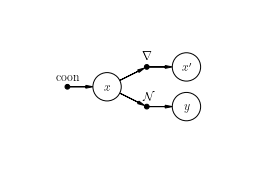

In [6]:
coon = CoonPrior()
x_shape = coon.size
noise = GaussianChannel(var=0.5)
grad_shape = (2,) + x_shape
teacher = (
    coon @ SIMOVariable("x", n_next=2) @ (
        GradientChannel(x_shape) @ O("x'") + 
        noise @ O("y")
    )
).to_model()
teacher.plot()

grad_rho=0.896 grad_var=0.065 grad_scale=0.166


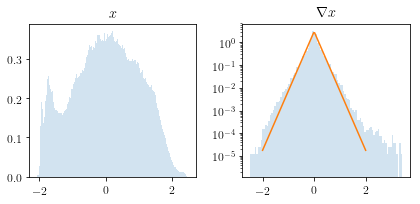

In [7]:
sample = teacher.sample()
plot_histograms(sample)    

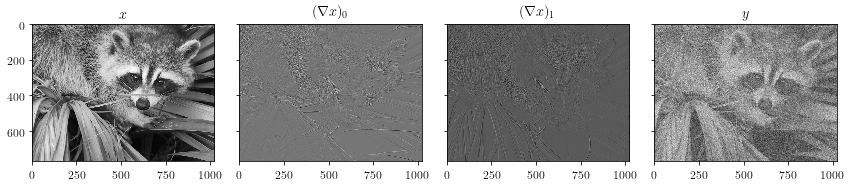

In [8]:
plot_data(sample, sample["y"])

## Sparse gradient denoising

In [9]:
# sparse grad denoiser
grad_shape = (2,) + x_shape

sparse_grad = (
    GaussianPrior(size=x_shape) @
    SIMOVariable(id="x", n_next=2) @ (
        noise @ O("y") + (
            GradientChannel(shape=x_shape) +
            GaussBernouilliPrior(size=grad_shape, var=0.7, rho=0.9)
        ) @
        MILeafVariable(id="x'", n_prev=2)
    )
).to_model()

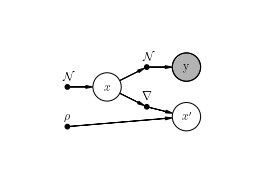

In [10]:
scenario = TeacherStudentScenario(teacher, sparse_grad, x_ids=["x", "x'"])
scenario.setup(seed=1)
scenario.student.plot()

In [11]:
_ = scenario.run_ep(max_iter=100, damping=0.1)

INFO:tramp.algos.message_passing:init message dag with ConstantInit(a=0,b=0)
INFO:tramp.algos.message_passing:f_1->x damping=0.1
INFO:tramp.algos.message_passing:f_2->x' damping=0.1
INFO:tramp.algos.message_passing:f_0->x' damping=0.1
INFO:tramp.algos.message_passing:x<-f_2 damping=0.1
INFO:tramp.algos.message_passing:x<-f_3 damping=0.1
INFO:tramp.algos.callbacks:early stopping all tolerances (on r) are below tol=1.00e-06
INFO:tramp.algos.message_passing:terminated after n_iter=25 iterations


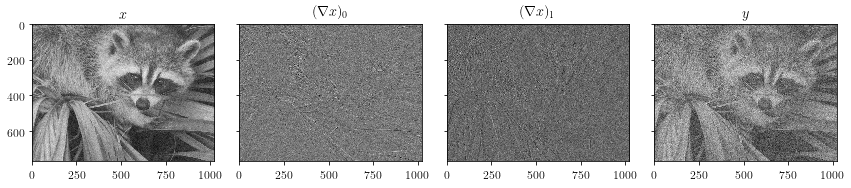

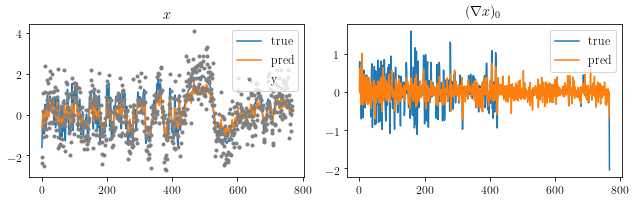

In [12]:
plot_data(scenario.x_pred, scenario.observations["y"])
compare_hcut(scenario.x_true, scenario.x_pred, scenario.observations["y"], h=20)

## Total variation denoising

We need to set initial conditions a=b=1. For a=b=0 ExpectationPropagation diverges.

In [13]:
# TV denoiser
tv_denoiser = (
    GaussianPrior(size=x_shape) @
    SIMOVariable(id="x", n_next=2) @ (
        noise @ O("y") + (
            GradientChannel(shape=x_shape) +
            MAP_L21NormPrior(size=grad_shape, scale=1)
        ) @
        MILeafVariable(id="x'", n_prev=2)
    )
).to_model()

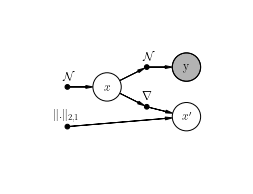

In [14]:
scenario2 = TeacherStudentScenario(teacher, tv_denoiser, x_ids=["x", "x'"])
scenario2.setup(seed=1)
scenario2.student.plot()

In [15]:
from tramp.algos import ConstantInit
_ = scenario2.run_ep(max_iter=100, damping=0, initializer=ConstantInit(a=1, b=1))

/Users/antoinebaker/Documents/projects/ml_physics/tramp/priors/map_L21_norm_prior.py:28: UserWarning: MAP_L21NormPrior.sample not implemented return zero array as a placeholder
  "MAP_L21NormPrior.sample not implemented "
INFO:tramp.algos.message_passing:init message dag with ConstantInit(a=1,b=1)
INFO:tramp.algos.message_passing:no damping
INFO:tramp.algos.callbacks:increase=0.36945847043616253 above max_increase=2.00e-01
INFO:tramp.algos.callbacks:restoring old message dag
INFO:tramp.algos.message_passing:terminated after n_iter=7 iterations


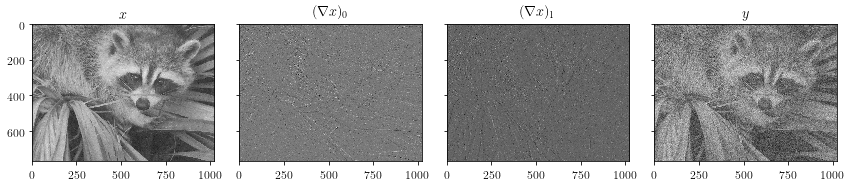

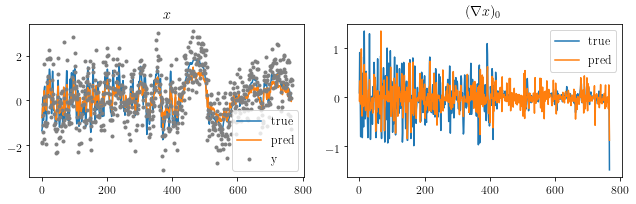

In [16]:
plot_data(scenario2.x_pred, scenario2.observations["y"])
compare_hcut(scenario2.x_true, scenario2.x_pred, scenario2.observations["y"], h=25)